In [1]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.collections import PatchCollection
from dask.distributed import Client, wait
from matplotlib.patches import Polygon
#import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


In [2]:
# parameters
connectivity_file = "../../output_data/035_connection_count_bio_phys_agg.nc"

In [3]:
####DASK
#client = Client(n_workers=8, threads_per_worker=4, memory_limit=32e9, ip="0.0.0.0")
client = Client(scheduler_file="../../scheduler.json")
# client.re.start()
client

<Client: 'tcp://10.0.5.41:8786' processes=0 threads=0, memory=0 B>

### habitable to habitable with dask

In [8]:
#habitable to habitable with superfast dask arrays
ds_conn = xr.open_dataset(
    connectivity_file,
    chunks={"year": 1, "month": 1, "hex0": 2100, "hex1": 2100},
)
ds_conn

<xarray.Dataset>
Dimensions:              (hex0: 8377, hex1: 8377, month: 5, year: 4, corner: 7)
Coordinates: (12/13)
  * hex0                 (hex0) object '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1                 (hex1) object '(-1, -19, 20)' ... '(9, 9, -18)'
  * month                (month) float64 0.0 1.0 2.0 3.0 4.0
  * year                 (year) float64 0.0 1.0 2.0 3.0
    lon_hex0_corners     (corner, hex0) float64 dask.array<chunksize=(7, 2100), meta=np.ndarray>
    lat_hex0_corners     (corner, hex0) float64 dask.array<chunksize=(7, 2100), meta=np.ndarray>
    ...                   ...
    lat_hex1_corners     (corner, hex1) float64 dask.array<chunksize=(7, 2100), meta=np.ndarray>
    lon_hex0             (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lon_hex1             (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0             (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex1             (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label            (hex0) object dask.array<chunksize=(2100,), meta=np.ndarray>
Dimensions without coordinates: corner
Data variables: (12/25)
    aqc_count_hex0       (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    rst_count_hex0       (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    pop_count_hex0       (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    dss_count_hex0       (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hly_count_hex0       (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    his_count_hex0       (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    ...                   ...
    depth_mean_hex0      (hex0) float32 dask.array<chunksize=(2100,), meta=np.ndarray>
    depth_mean_hex1      (hex1) float32 dask.array<chunksize=(2100,), meta=np.ndarray>
    depth_median_hex0    (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    depth_median_hex1    (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    depth_std_hex0       (hex0) float32 dask.array<chunksize=(2100,), meta=np.ndarray>
    depth_std_hex1       (hex1) float32 dask.array<chunksize=(2100,), meta=np.ndarray>
Attributes:
    hex_proj__lon_origin:       -3.0
    hex_proj__lat_origin:       54.5
    hex_proj__hex_size_meters:  10000

### Labellig habitable zones

- depth < 90m
- rest site
- aquaculture
- historic site
- known disease site
- known healthy site

### Normalization

In [9]:
ds_conn["obs_per_origin_area"] = ds_conn.obs / ds_conn.water_fraction_hex0


In [10]:
ds_conn["habitable_hex0"] = (
    (ds_conn.depth_median_hex0 < 90)
    | (ds_conn.his_count_hex0 > 0)
    | (ds_conn.rst_count_hex0 > 0)
    | (ds_conn.aqc_count_hex0 > 0)
    | (ds_conn.dss_count_hex0 > 0)
    | (ds_conn.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn["habitable_hex1"] = (
    (ds_conn.depth_median_hex1 < 90)
    | (ds_conn.rst_count_hex1 > 0)
    | (ds_conn.his_count_hex1 > 0)
    | (ds_conn.aqc_count_hex1 > 0)
    | (ds_conn.dss_count_hex1 > 0)
    | (ds_conn.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [11]:
habitable_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.habitable_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
)
habitable_to_habitable_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 8377,
                                         hex1: 8377)>
dask.array<where, shape=(5, 4, 8377, 8377), dtype=float64, chunksize=(1, 1, 2100, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(2100,), meta=np.ndarray>

In [10]:
#calculate distances between hex0 and hex1
lon_hex0 = habitable_to_habitable_01y.lon_hex0
lat_hex0 = habitable_to_habitable_01y.lat_hex0
lon_hex1 = habitable_to_habitable_01y.lon_hex1
lat_hex1 = habitable_to_habitable_01y.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [11]:
#here we use a dask array because the matrix is much larger (way more hex0)
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-bae01e1355925f259a0d1ce58e16f838' (dist: 100)>
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 0.0 23.98 47.97 ... 2.327e+03 2.351e+03 2.374e+03

In [12]:
dist_kernel_weights = habitable_to_habitable_01y.sum("hex1")

dist_kernels = (
    habitable_to_habitable_01y.where(dist >= dist_thresholds).sum("hex1")
    / dist_kernel_weights
)

dist_kernels = dist_kernels.compute()
dist_kernels

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 8377,
                                         dist: 100)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [1.        , 0.69450332, 0.00452169, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.77068767, 0.41466974, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [1.        , 0.99914576, 0.81687798, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.99687603, 0.73788328, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.99553374, 0.79101423, ..., 0.        ,
          0.        , 0.        ]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [1.        , 0.73870755, 0.01813386, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.77342094, 0.07912957, ..., 0.        ,
          0.        , 0.        ],
...
         [1.        , 1.        , 0.96911249, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 1.        , 0.96909001, ..., 0.        ,
          0.        , 0.        ],
         [1.        , 1.        , 0.93414745, ..., 0.        ,
          0.        , 0.        ]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * hex0       (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * dist       (dist) float64 0.0 23.98 47.97 ... 2.327e+03 2.351e+03 2.374e+03

In [13]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

#change years and months from numbers to actual names before plotting
year_name_mapping = {
    0: '2019',
    1: '2020',
    2: '2021',
    3: '2022',
}

month_name_mapping = {
    0: 'May',
    1: 'June',
    2: 'July',
    3: 'August',
    4: 'September',
}

dist_kernels_df['year'] = dist_kernels_df['year'].map(year_name_mapping).fillna(dist_kernels_df['year'])
dist_kernels_df['month'] = dist_kernels_df['month'].map(month_name_mapping).fillna(dist_kernels_df['month'])
dist_kernels_df.head(5)

month  year           hex0       dist  lon_hex0   lat_hex0      hex_label  \
0   May  2019  (-1, -19, 20)   0.000000 -3.215782  51.464504  (-1, -19, 20)   
1   May  2019  (-1, -19, 20)  23.984779 -3.215782  51.464504  (-1, -19, 20)   
2   May  2019  (-1, -19, 20)  47.969558 -3.215782  51.464504  (-1, -19, 20)   
3   May  2019  (-1, -19, 20)  71.954336 -3.215782  51.464504  (-1, -19, 20)   
4   May  2019  (-1, -19, 20)  95.939115 -3.215782  51.464504  (-1, -19, 20)   

   obs_per_origin_area  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

In [12]:
hex_patches = []
for _lon, _lat in zip(
    ds_conn.lon_hex1_corners.data.T,
    ds_conn.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 


fig, ax = plt.subplots(
    1, 1,
    #subplot_kw={"projection": cartopy.crs.Stereographic(
    #    central_longitude=ds_conn.hex_proj__lon_origin,
    #    central_latitude=ds_conn.hex_proj__lat_origin,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();

cmap = 'plasma'

p = PatchCollection(
    hex_patches, cmap=cmap,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

#particle number logged
p.set_array(
    habitable_to_habitable_01y.sum(["hex0", "year", "month"]).where(
        habitable_to_habitable_01y.sum(["hex0", "year", "month"]) > 0,
    )
)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Habitable-habitable, dispersal after 1 year", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_habitable-habitable_1y.pdf")

KeyboardInterrupt: 

In [ ]:
dist_kernels.mean(["year", "month", "hex0"]).plot()
dist_kernels.quantile(dim=["year", "month", "hex0"], q=0.9).plot()
dist_kernels.quantile(dim=["year", "month", "hex0"], q=0.1).plot()


## Dispersal kernels

### Distance: Disease to habitable

In [12]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.habitable_hex1 > 0)
)

dss_to_habitable_01y
#this xarray has information on how many particles dispersed from the 66 diseased hex0 to the connected hex1, and in which month + year the simulations were run

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

In [13]:
#calculate distances between hex0 and hex1
lon_hex0 = dss_to_habitable_01y.lon_hex0
lat_hex0 = dss_to_habitable_01y.lat_hex0
lon_hex1 = dss_to_habitable_01y.lon_hex1
lat_hex1 = dss_to_habitable_01y.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1
dist

<xarray.DataArray (hex0: 67, hex1: 8377)>
dask.array<pow, shape=(67, 8377), dtype=float64, chunksize=(26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>

In [16]:
dist = dist.compute()
dist

<xarray.DataArray (hex0: 67, hex1: 8377)>
array([[ 294.82499971,  589.35027037,  277.49222019, ...,  845.24877107,
         862.30158509,  879.36494071],
       [ 433.71573295,  728.24100908,  416.38295323, ...,  982.2646715 ,
         999.38718147, 1016.51648519],
       [ 137.1470216 ,  300.46546671,  141.45255303, ...,  585.04040907,
         600.24194872,  615.55589883],
       ...,
       [ 256.48311749,  538.94590697,  240.76334001, ...,  772.33996095,
         789.62791734,  806.91713796],
       [ 321.09919728,  607.18570383,  304.76494763, ...,  841.63903726,
         858.9315331 ,  876.22502011],
       [ 164.9317099 ,  393.50867416,  158.41882245, ...,  606.27011257,
         623.58512373,  640.90015527]])
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
    lon_hex0   (hex0) float64 -3.204 -3.199 -5.168 ... -1.762 -1.778 -1.085
    lat_hex0   (hex0) float64 48.82 47.57 51.68 50.12 ... 49.35 48.73 50.83
    hex_label  (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex1   (hex1) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lat_hex1   (hex1) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58

In [17]:
#
dist_thresholds = xr.DataArray(
    np.linspace(0, dist.max(), 1000),
    dims=("dist", ),
    coords={"dist": (("dist", ), np.linspace(0, dist.max(), 1000))},
)
dist_thresholds

<xarray.DataArray (dist: 1000)>
array([   0.        ,    1.95192231,    3.90384462,    5.85576693,
          7.80768924,    9.75961155,   11.71153386,   13.66345617,
         15.61537848,   17.56730079,   19.5192231 ,   21.47114541,
         23.42306772,   25.37499003,   27.32691234,   29.27883465,
         31.23075696,   33.18267927,   35.13460158,   37.08652389,
         39.0384462 ,   40.99036851,   42.94229082,   44.89421314,
         46.84613545,   48.79805776,   50.74998007,   52.70190238,
         54.65382469,   56.605747  ,   58.55766931,   60.50959162,
         62.46151393,   64.41343624,   66.36535855,   68.31728086,
         70.26920317,   72.22112548,   74.17304779,   76.1249701 ,
         78.07689241,   80.02881472,   81.98073703,   83.93265934,
         85.88458165,   87.83650396,   89.78842627,   91.74034858,
         93.69227089,   95.6441932 ,   97.59611551,   99.54803782,
        101.49996013,  103.45188244,  105.40380475,  107.35572706,
        109.30764937,  111.25957168,  113.21149399,  115.1634163 ,
        117.11533861,  119.06726092,  121.01918323,  122.97110554,
        124.92302785,  126.87495016,  128.82687247,  130.77879479,
        132.7307171 ,  134.68263941,  136.63456172,  138.58648403,
        140.53840634,  142.49032865,  144.44225096,  146.39417327,
        148.34609558,  150.29801789,  152.2499402 ,  154.20186251,
...
       1795.76852541, 1797.72044772, 1799.67237003, 1801.62429234,
       1803.57621465, 1805.52813696, 1807.48005927, 1809.43198158,
       1811.38390389, 1813.3358262 , 1815.28774851, 1817.23967082,
       1819.19159313, 1821.14351544, 1823.09543775, 1825.04736006,
       1826.99928237, 1828.95120468, 1830.90312699, 1832.8550493 ,
       1834.80697161, 1836.75889392, 1838.71081623, 1840.66273854,
       1842.61466085, 1844.56658316, 1846.51850547, 1848.47042778,
       1850.42235009, 1852.3742724 , 1854.32619471, 1856.27811702,
       1858.23003933, 1860.18196164, 1862.13388395, 1864.08580627,
       1866.03772858, 1867.98965089, 1869.9415732 , 1871.89349551,
       1873.84541782, 1875.79734013, 1877.74926244, 1879.70118475,
       1881.65310706, 1883.60502937, 1885.55695168, 1887.50887399,
       1889.4607963 , 1891.41271861, 1893.36464092, 1895.31656323,
       1897.26848554, 1899.22040785, 1901.17233016, 1903.12425247,
       1905.07617478, 1907.02809709, 1908.9800194 , 1910.93194171,
       1912.88386402, 1914.83578633, 1916.78770864, 1918.73963095,
       1920.69155326, 1922.64347557, 1924.59539788, 1926.54732019,
       1928.4992425 , 1930.45116481, 1932.40308712, 1934.35500943,
       1936.30693174, 1938.25885405, 1940.21077636, 1942.16269867,
       1944.11462098, 1946.06654329, 1948.0184656 , 1949.97038792])
Coordinates:
  * dist     (dist) float64 0.0 1.952 3.904 ... 1.946e+03 1.948e+03 1.95e+03

In [18]:
dist_kernel_weights = dss_to_habitable_01y.sum("hex1")

dist_kernels = (
    dss_to_habitable_01y.where(dist >= dist_thresholds).sum("hex1")
    / dist_kernel_weights
).compute()
#dist_kernels

In [19]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

month  year           hex0         dist  lon_hex0   lat_hex0  \
0          0.0   0.0  (-1, -36, 37)     0.000000 -3.204015  48.815593   
1          0.0   0.0  (-1, -36, 37)     1.951922 -3.204015  48.815593   
2          0.0   0.0  (-1, -36, 37)     3.903845 -3.204015  48.815593   
3          0.0   0.0  (-1, -36, 37)     5.855767 -3.204015  48.815593   
4          0.0   0.0  (-1, -36, 37)     7.807689 -3.204015  48.815593   
...        ...   ...            ...          ...       ...        ...   
1339995    4.0   3.0   (9, -28, 19)  1942.162699 -1.084634  50.825433   
1339996    4.0   3.0   (9, -28, 19)  1944.114621 -1.084634  50.825433   
1339997    4.0   3.0   (9, -28, 19)  1946.066543 -1.084634  50.825433   
1339998    4.0   3.0   (9, -28, 19)  1948.018466 -1.084634  50.825433   
1339999    4.0   3.0   (9, -28, 19)  1949.970388 -1.084634  50.825433   

             hex_label  obs_per_origin_area  
0        (-1, -36, 37)                  1.0  
1        (-1, -36, 37)                  1.0  
2        (-1, -36, 37)                  1.0  
3        (-1, -36, 37)                  1.0  
4        (-1, -36, 37)                  1.0  
...                ...                  ...  
1339995   (9, -28, 19)                  NaN  
1339996   (9, -28, 19)                  NaN  
1339997   (9, -28, 19)                  NaN  
1339998   (9, -28, 19)                  NaN  
1339999   (9, -28, 19)                  NaN  

[1340000 rows x 8 columns]

In [20]:
#change years and months from numbers to actual names before plotting
year_name_mapping = {
    0: '2019',
    1: '2020',
    2: '2021',
    3: '2022',
}

month_name_mapping = {
    0: 'May',
    1: 'June',
    2: 'July',
    3: 'August',
    4: 'September',
}

dist_kernels_df['year'] = dist_kernels_df['year'].map(year_name_mapping).fillna(dist_kernels_df['year'])
dist_kernels_df['month'] = dist_kernels_df['month'].map(month_name_mapping).fillna(dist_kernels_df['month'])
dist_kernels_df.head(5)

month  year           hex0      dist  lon_hex0   lat_hex0      hex_label  \
0   May  2019  (-1, -36, 37)  0.000000 -3.204015  48.815593  (-1, -36, 37)   
1   May  2019  (-1, -36, 37)  1.951922 -3.204015  48.815593  (-1, -36, 37)   
2   May  2019  (-1, -36, 37)  3.903845 -3.204015  48.815593  (-1, -36, 37)   
3   May  2019  (-1, -36, 37)  5.855767 -3.204015  48.815593  (-1, -36, 37)   
4   May  2019  (-1, -36, 37)  7.807689 -3.204015  48.815593  (-1, -36, 37)   

   obs_per_origin_area  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0

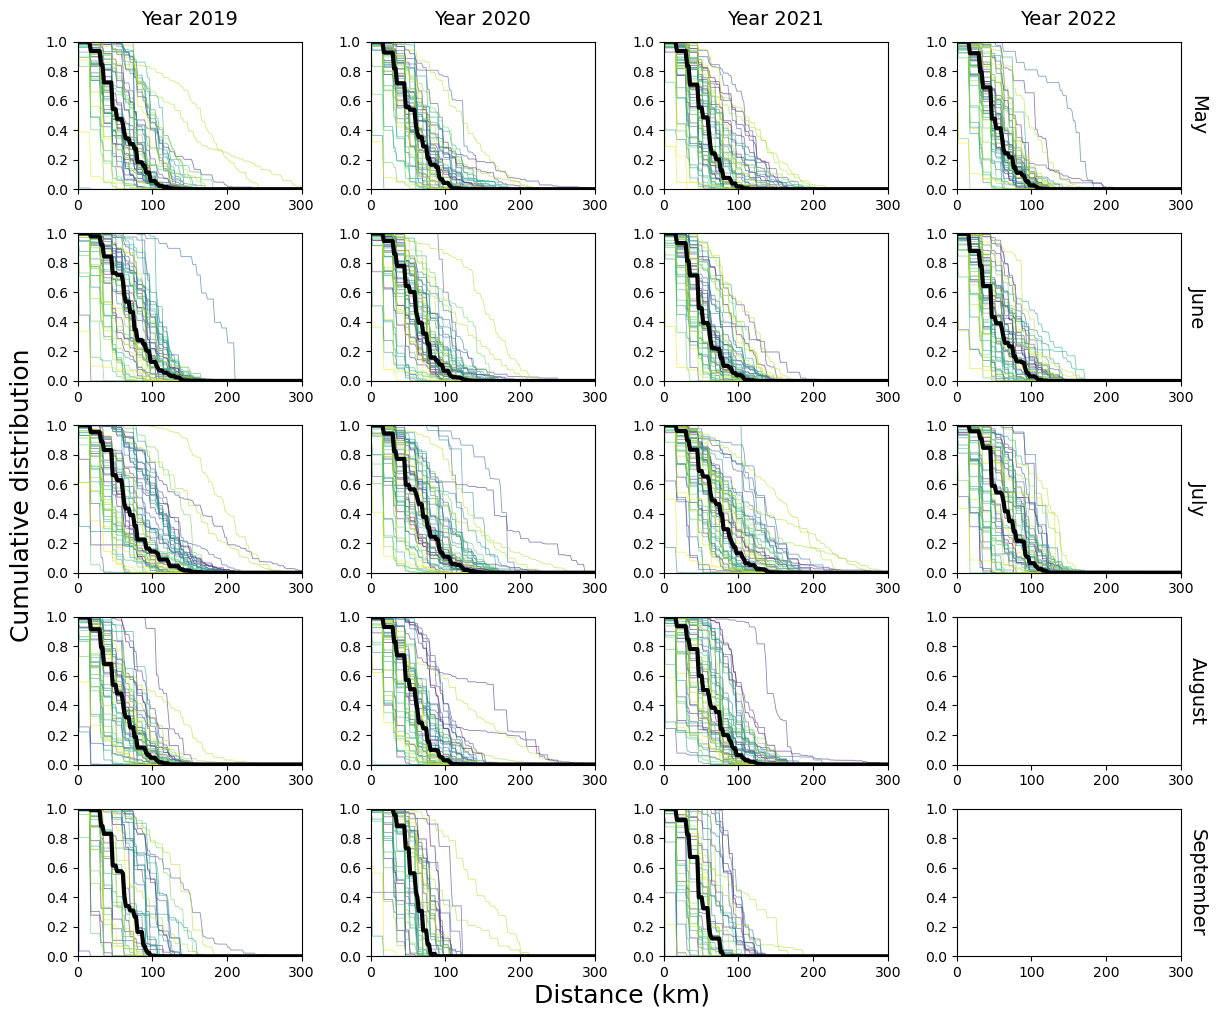

In [20]:
# Get unique years and months because later we want to create subplots for each month in each year
years = dist_kernels_df['year'].unique()
months = dist_kernels_df['month'].unique()
#prep colors for hex0 lines
color_map = plt.cm.viridis

# Create subplots 
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, figsize=(12, 10))

#create labels on the right side of the big plot for months (needs to be here for some reason, didnt work when plotted later)
for j, month in enumerate(months):
    axes[j, -1].yaxis.set_label_position("right")
    axes[j, -1].set_ylabel(f'{month}', rotation=270, ha='center', va='center', labelpad=12, size=14)

#not fill in plots
for i, year in enumerate(years):
    for j, month in enumerate(months):
        ax = axes[j, i]
        subset = dist_kernels_df[(dist_kernels_df['year'] == year) & (dist_kernels_df['month'] == month)]
        hex0_values = subset['hex0'].unique()
        
        #plot a line for each hex0 per subplot and color according to label
        for idx, hex0_value in enumerate(hex0_values):
            hex0_subset = subset[subset['hex0'] == hex0_value]
            color = color_map(idx / len(hex0_values))  # Assign a color based on index
            ax.plot(hex0_subset['dist'], hex0_subset['obs_per_origin_area'], label=f'hex0={hex0_value}', color=color, alpha=0.6, linewidth = 0.6)
        #add median curve
        median_curve = subset.groupby('dist')['obs_per_origin_area'].median()
        ax.plot(median_curve.index, median_curve.values, zorder = 10, linewidth = 3, color = 'black')
        #set limits
        ax.set_xlim(0, 300)
        ax.set_ylim(0, 1)
        # Hide y-axes (ticks and labels) for subplots except the leftmost one
        #if i != 0:
        #    ax.yaxis.set_visible(False)
        # Hide x-axes (ticks and labels) for subplots except the bottommost one
        #if j != num_months - 1:
        #    ax.xaxis.set_visible(False)

plt.subplots_adjust(right=0.85, bottom=0.15)  # Adjust the subplot layout
#overall labels on axes
fig.text(0, 0.5, 'Cumulative distribution', ha='center', va='center', rotation='vertical', size = 18)
fig.text(0.5, 0, 'Distance (km)', ha='center', va='center', size = 18)

# Add corresponding years (top) for each column
for i, year in enumerate(years):
    axes[0, i].set_title(f'Year {int(year)}', pad=12, size = 14)

plt.tight_layout()
plt.show()

fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hex0yearmonth.pdf")

In [24]:
dist_50 = []
years = dist_kernels_df['year'].unique()
months = dist_kernels_df['month'].unique()

for i, year in enumerate(years):
    for j, month in enumerate(months):
        subset = dist_kernels_df[(dist_kernels_df['year'] == year) & (dist_kernels_df['month'] == month)]
        
        if (subset['obs_per_origin_area'] <= 0.5).any():
            distance_at_50_percent = subset[subset['obs_per_origin_area'] <= 0.5]['dist'].iloc[0]
            dist_50.append((year, month, distance_at_50_percent))

dist_50

[('2019', 'May', 52.70190237608143),
 ('2019', 'June', 80.02881471923476),
 ('2019', 'July', 60.509591616982384),
 ('2019', 'August', 87.83650396013572),
 ('2019', 'September', 17.567300792027144),
 ('2020', 'May', 52.70190237608143),
 ('2020', 'June', 46.846135445405714),
 ('2020', 'July', 64.41343623743286),
 ('2020', 'August', 87.83650396013572),
 ('2020', 'September', 91.74034858058619),
 ('2021', 'May', 46.846135445405714),
 ('2021', 'June', 60.509591616982384),
 ('2021', 'July', 64.41343623743286),
 ('2021', 'August', 105.40380475216286),
 ('2021', 'September', 93.69227089081143),
 ('2022', 'May', 46.846135445405714),
 ('2022', 'June', 60.509591616982384),
 ('2022', 'July', 80.02881471923476)]

In [21]:
#calculate characteristic dist 

delta_dist = dist_thresholds.values[1] - dist_thresholds.values[0]

dist_characteristic = dist_kernels.sum("dist") * delta_dist
dist_characteristic

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67)>
array([[[ 57.95629429,  57.07385746,  47.69761548, ...,  45.37302296,
          11.33512184,   0.        ],
        [ 50.94169706,  62.58900005,  60.36399502, ...,  55.80599796,
           9.99296526,   0.        ],
        [ 45.95436594,  98.3800417 ,  78.5768426 , ...,  61.11989124,
           9.16817845,  20.6486737 ],
        [ 50.98726123,  56.11132699,  43.34272165, ...,  49.03167061,
          11.20568268,   0.        ]],

       [[ 77.09056161,  71.96009233,  65.34530474, ...,  55.82798994,
          12.95216842,   0.        ],
        [ 52.04180791,  56.40359825,  40.98637514, ...,  44.9356156 ,
          11.33905211,  23.4636121 ],
        [ 54.86497139,  58.58064089,  85.58460946, ...,  45.16607769,
          12.68094824,   0.        ],
        [ 59.80688464,  63.46642125,  46.92172113, ...,  44.64490297,
          11.47475747,   0.        ]],

       [[ 63.36153481,  79.85384124,  56.69856547, ...,  51.43923453,
          21.15527024,   0.        ],
...
        [ 78.87981594,  65.32932793,  44.55745551, ...,  55.48426048,
          13.71218666,   0.        ]],

       [[ 84.84178019,  62.05258296,  32.61695964, ...,  68.36651332,
          20.27185167,   0.        ],
        [ 91.64166089,  55.81773254,  36.99965718, ...,  61.71888982,
          22.61356517,   0.        ],
        [108.73809736,  68.47198051,  53.29761605, ...,  76.65625945,
          22.54263319,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,  22.81490202,   0.        , ...,  68.04795033,
          38.00359916,   0.        ],
        [ 90.09974919,  78.28926773,  38.92928826, ...,  66.35956649,
          11.45378744,   0.        ],
        [ 96.10176549,  62.5497979 ,  30.80155971, ...,  37.35875045,
           5.57388695,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 -3.204 -3.199 -5.168 ... -1.762 -1.778 -1.085
    lat_hex0   (hex0) float64 48.82 47.57 51.68 50.12 ... 49.35 48.73 50.83
    hex_label  (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'

In [22]:
#plot dist_characteristic
#prep hexes
hex_patches = []
for _lon, _lat in zip(
    ds_conn.lon_hex1_corners.data.T,
    ds_conn.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 
    
##didnt manage yet to only fill the 66 hex0 in the dist_characteristic list; all are currently filled... 

fig, ax = plt.subplots(
    1, 1,
    #subplot_kw={"projection": cartopy.crs.Stereographic(
    #    central_longitude=ds_conn.hex_proj__lon_origin,
    #    central_latitude=ds_conn.hex_proj__lat_origin,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();


p = PatchCollection(
    hex_patches,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

# Flatten the DataArray
flat_data = dist_characteristic.values.ravel()

# Set the 1D array to the PatchCollection
p.set_array(flat_data)

cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16) 

#ax.scatter(
#    dss_to_habitable_01y.lon_hex0, dss_to_habitable_01y.lat_hex0,
#    s=20, 
#    c="red",
#    transform=cartopy.crs.PlateCarree()
#)

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Any known disease site to any habitat, typical year", fontsize=16);

KeyboardInterrupt: 

### multiply kernels

In [28]:
#example how to multiply kernals: 
#we sum over year and month and only retrieve hex0
#from this we can plot the dispersal kernel for each hex0 and calculate dist_50 per hex0

dist_kernels_hex0 =(
    (dist_kernels * dist_kernel_weights).sum(["year", "month"])
    / dist_kernel_weights.sum(["year", "month"])
).compute()

dist_kernels_hex0
#dist_kernels_hex0.plot(col="hex0", col_wrap=6)

<xarray.DataArray 'obs_per_origin_area' (hex0: 67, dist: 1000)>
array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.99604807, 0.99604807, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.97885805, 0.97885805, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.99898033, 0.99898033, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.42485783, 0.42485783, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
    lon_hex0   (hex0) float64 -3.204 -3.199 -5.168 ... -1.762 -1.778 -1.085
    lat_hex0   (hex0) float64 48.82 47.57 51.68 50.12 ... 49.35 48.73 50.83
    hex_label  (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * dist       (dist) float64 0.0 1.952 3.904 ... 1.946e+03 1.948e+03 1.95e+03

In [29]:
#transform to dataframe # with reset_index() month year hex0 and dst from indices to columns
dist_kernels_hex0_df = dist_kernels_hex0.to_dataframe().reset_index()
dist_kernels_hex0_df

hex0         dist  lon_hex0   lat_hex0      hex_label  \
0      (-1, -36, 37)     0.000000 -3.204015  48.815593  (-1, -36, 37)   
1      (-1, -36, 37)     1.951922 -3.204015  48.815593  (-1, -36, 37)   
2      (-1, -36, 37)     3.903845 -3.204015  48.815593  (-1, -36, 37)   
3      (-1, -36, 37)     5.855767 -3.204015  48.815593  (-1, -36, 37)   
4      (-1, -36, 37)     7.807689 -3.204015  48.815593  (-1, -36, 37)   
...              ...          ...       ...        ...            ...   
66995   (9, -28, 19)  1942.162699 -1.084634  50.825433   (9, -28, 19)   
66996   (9, -28, 19)  1944.114621 -1.084634  50.825433   (9, -28, 19)   
66997   (9, -28, 19)  1946.066543 -1.084634  50.825433   (9, -28, 19)   
66998   (9, -28, 19)  1948.018466 -1.084634  50.825433   (9, -28, 19)   
66999   (9, -28, 19)  1949.970388 -1.084634  50.825433   (9, -28, 19)   

       obs_per_origin_area  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
66995                  0.0  
66996                  0.0  
66997                  0.0  
66998                  0.0  
66999                  0.0  

[67000 rows x 6 columns]

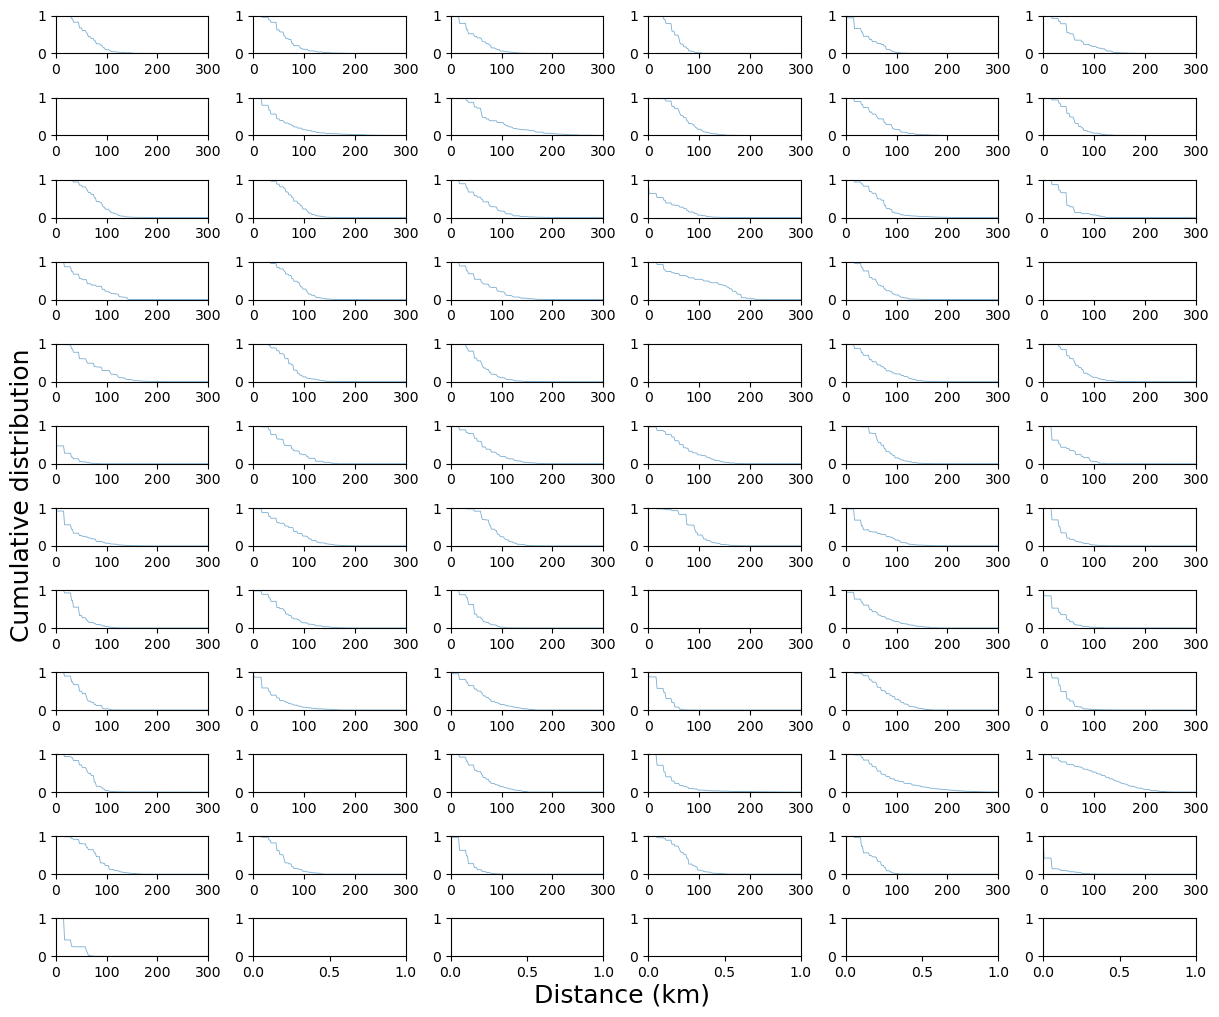

In [31]:
# Get unique hex0 because later we want to create subplots for each hex0
hex0_values = dist_kernels_hex0_df['hex0'].unique()
num_hex0 = len(hex0_values)

num_columns = 6
num_rows = (num_hex0 + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))

axes = axes.ravel()

for i, hex0_value in enumerate(hex0_values):
    ax = axes[i]
    hex0_subset = dist_kernels_hex0_df[dist_kernels_hex0_df['hex0'] == hex0_value]
    #color = color_map(idx / len(hex0_values))  # Assign a color based on index
    ax.plot(hex0_subset['dist'], hex0_subset['obs_per_origin_area'], label=f'hex0={hex0_value}', alpha=0.6, linewidth = 0.6)
        #add median curve
        #median_curve = subset.groupby('dist')['obs_per_origin_area'].median()
        #ax.plot(median_curve.index, median_curve.values, zorder = 10, linewidth = 3, color = 'black')
        #set limits
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 1)
        # Hide y-axes (ticks and labels) for subplots except the leftmost one
        #if i != 0:
        #    ax.yaxis.set_visible(False)
        # Hide x-axes (ticks and labels) for subplots except the bottommost one
        #if j != num_months - 1:
        #    ax.xaxis.set_visible(False)

plt.subplots_adjust(right=0.85, bottom=0.15)  # Adjust the subplot layout
#overall labels on axes
fig.text(0, 0.5, 'Cumulative distribution', ha='center', va='center', rotation='vertical', size = 18)
fig.text(0.5, 0, 'Distance (km)', ha='center', va='center', size = 18)

# Add corresponding years (top) for each column
#for i, year in enumerate(years):
#    axes[0, i].set_title(f'Year {int(year)}', pad=12, size = 14)

plt.tight_layout()
plt.show()

fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hex0.pdf")

In [32]:
#calculate dist_50 for each hex0
dist_50 = []
hex0_values = dist_kernels_hex0_df['hex0'].unique()

for i, hex0_value in enumerate(hex0_values):
    hex0_subset = dist_kernels_hex0_df[dist_kernels_hex0_df['hex0'] == hex0_value]
    if (hex0_subset['obs_per_origin_area'] <= 0.5).any():
        distance_at_50_percent = hex0_subset[hex0_subset['obs_per_origin_area'] <= 0.5]['dist'].iloc[0]
        dist_50.append((hex0_value, distance_at_50_percent))

dist_50

[('(-1, -36, 37)', 64.41343623743286),
 ('(-1, -44, 45)', 60.509591616982384),
 ('(-10, -13, 23)', 46.846135445405714),
 ('(-10, -23, 33)', 52.70190237608143),
 ('(-11, 14, -3)', 35.13460158405429),
 ('(-11, 5, 6)', 60.509591616982384),
 ('(-16, 13, 3)', 46.846135445405714),
 ('(-19, 15, 4)', 62.46151392720762),
 ('(-2, -35, 37)', 70.26920316810858),
 ('(-2, -43, 45)', 62.46151392720762),
 ('(-24, -5, 29)', 52.70190237608143),
 ('(-3, -35, 38)', 80.02881471923476),
 ('(-3, -36, 39)', 80.02881471923476),
 ('(-3, -42, 45)', 60.509591616982384),
 ('(-30, 12, 18)', 31.23075696360381),
 ('(-30, 15, 15)', 62.46151392720762),
 ('(-30, 9, 21)', 46.846135445405714),
 ('(-31, 11, 20)', 62.46151392720762),
 ('(-4, -35, 39)', 80.02881471923476),
 ('(-4, -41, 45)', 60.509591616982384),
 ('(-4, 24, -20)', 109.30764937261333),
 ('(-5, -34, 39)', 60.509591616982384),
 ('(-5, -40, 45)', 62.46151392720762),
 ('(-5, -5, 10)', 70.26920316810858),
 ('(-6, -34, 40)', 60.509591616982384),
 ('(-6, -40, 46)', 

In [33]:
import pandas as pd
dist_50_df = pd.DataFrame(dist_50, columns=['hex0', 'dist'])
dist_50_df
#some hex0 have dist 0, so here it is less than the initial 66 hex0

hex0       dist
0    (-1, -36, 37)  64.413436
1    (-1, -44, 45)  60.509592
2   (-10, -13, 23)  46.846135
3   (-10, -23, 33)  52.701902
4    (-11, 14, -3)  35.134602
..             ...        ...
57    (5, -27, 22)  31.230757
58    (5, -40, 35)  76.124970
59    (6, -36, 30)  46.846135
60    (6, -40, 34)   1.951922
61    (9, -28, 19)  17.567301

[62 rows x 2 columns]

### 1 Year: Disease to habitable (identification of potential new restroation sites)

In [14]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.habitable_hex1 > 0)
)

dss_to_habitable_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

#### 1 year: how many habitable sites are connected to each dss site? separated by month+year

In [19]:
nonzero_connections = dss_to_habitable_01y > 0

#count connections
connected_hex1_count_per_hex0 = nonzero_connections.sum(dim='hex1')

total_connected_hex1_count = connected_hex1_count_per_hex0.sum(dim=['month', 'year'])

connected_df = total_connected_hex1_count.to_dataframe(name='connected_hex1_count')

print(connected_df)

                lon_hex0   lat_hex0       hex_label  connected_hex1_count
hex0                                                                     
(-1, -36, 37)  -3.204015  48.815593   (-1, -36, 37)                   599
(-1, -44, 45)  -3.199006  47.567702   (-1, -44, 45)                   628
(-10, -13, 23) -5.168404  51.677740  (-10, -13, 23)                   738
(-10, -23, 33) -5.096416  50.120894  (-10, -23, 33)                   594
(-11, 14, -3)  -5.631080  55.794692   (-11, 14, -3)                   169
...                  ...        ...             ...                   ...
(5, -27, 22)   -1.939319  50.680946    (5, -27, 22)                   236
(5, -40, 35)   -1.983200  48.655073    (5, -40, 35)                   678
(6, -36, 30)   -1.762264  49.354450    (6, -36, 30)                   552
(6, -40, 34)   -1.777946  48.730928    (6, -40, 34)                   621
(9, -28, 19)   -1.084634  50.825433    (9, -28, 19)                    17

[67 rows x 4 columns]


In [15]:
dss_to_rst_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.rst_count_hex1 > 0)
)

dss_to_rst_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

In [16]:
%%time

hex_patches = []
for _lon, _lat in zip(
    ds_conn.lon_hex1_corners.data.T,
    ds_conn.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

CPU times: user 31.7 s, sys: 1.37 s, total: 33.1 s
Wall time: 3min 53s


In [17]:
#calculate relative concentration
heat_map = dss_to_habitable_01y.sum(["hex0", "year", "month"]).sum() #sum over

relative_concentration = dss_to_habitable_01y.sum(["hex0", "year", "month"]).where(
    dss_to_habitable_01y.sum(["hex0", "year", "month"]) > 0) / heat_map
relative_concentration

<xarray.DataArray 'obs_per_origin_area' (hex1: 8377)>
dask.array<truediv, shape=(8377,), dtype=float64, chunksize=(2100,), chunktype=numpy.ndarray>
Coordinates:
  * hex1      (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex1  (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex1  (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>

In [13]:
# filter the relative concentration at the restoration sites!

known_rst_sites = ds_conn.rst_count_hex1.where(ds_conn.rst_count_hex1 > 0)

filtered_concentration = relative_concentration[known_rst_sites > 0]
filtered_concentration = filtered_concentration.fillna(0)
filtered_concentration

<xarray.DataArray 'obs_per_origin_area' (hex1: 29)>
dask.array<where, shape=(29,), dtype=float64, chunksize=(17,), chunktype=numpy.ndarray>
Coordinates:
  * hex1      (hex1) object '(-11, 16, -5)' '(-11, 17, -6)' ... '(9, -58, 49)'
    lon_hex1  (hex1) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    lat_hex1  (hex1) float64 dask.array<chunksize=(5,), meta=np.ndarray>

CPU times: user 595 ms, sys: 366 ms, total: 961 ms
Wall time: 2.11 s


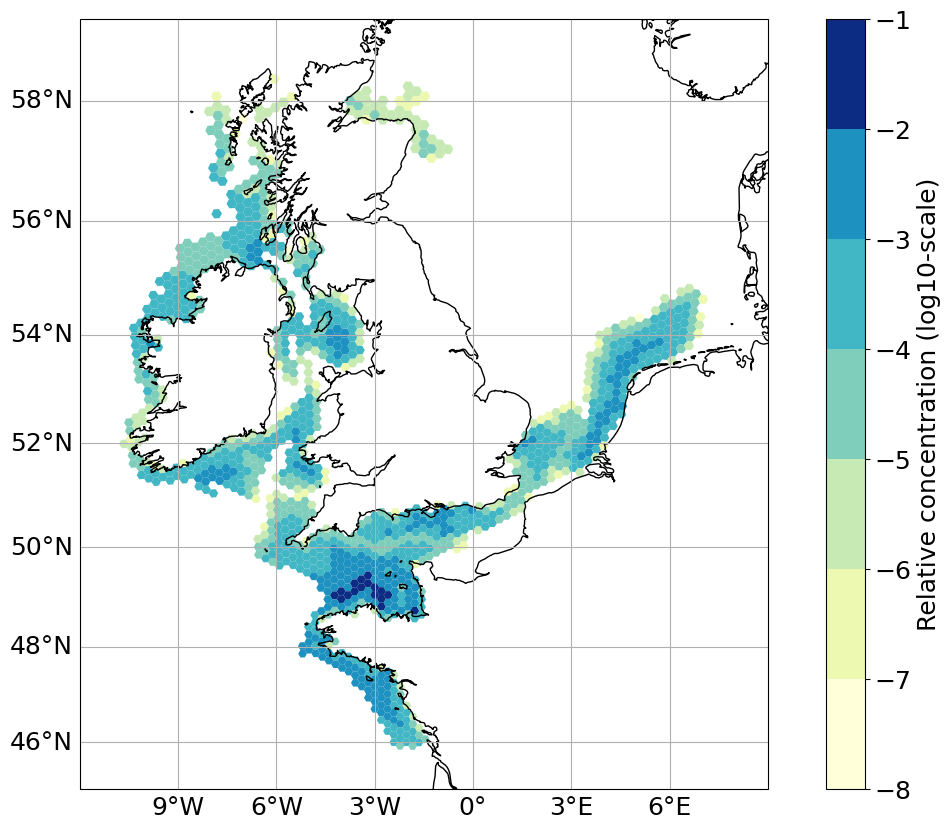

In [41]:
%%time
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hex2color

levels = [-8, -7, -6, -5, -4, -3, -2, -1]

hex_colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
colors = [hex2color(hex_color) for hex_color in hex_colors]

cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(levels))

norm = BoundaryNorm(levels, cmap.N)

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator(
    )},
    figsize=(12, 8),
)

fig.tight_layout();

p = PatchCollection(
    hex_patches, cmap=cmap,
    norm=norm,
    alpha=1.0,  
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

#relative concentration logged
p.set_array(np.log10(relative_concentration))


ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=18) 
cbar.set_label(r'Relative concentration (log10-scale)', fontsize=18)

ax.scatter(
    dss_to_habitable_01y.lon_hex0, dss_to_habitable_01y.lat_hex0,
    s=20, 
    c="red",
    transform=cartopy.crs.Mercator()
)

ax.set_extent([-12, 9, 45, 59])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

#ax.set_title("Any known disease site to any habitat, typical year", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_dss_habitable_1y_relativeconcentration_rst.pdf")

### 1 year: disease to habitable, separated by year

In [42]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.habitable_hex1 > 0)
)

dss_to_habitable_01y

2024-08-28 11:31:46,464 - distributed.client - WARNING - Couldn't gather 4 keys, rescheduling {"('any-aggregate-8ab96838733f7e344cb057bc2f5a2b7c', 2)": (), "('any-aggregate-8ab96838733f7e344cb057bc2f5a2b7c', 3)": (), "('any-aggregate-8ab96838733f7e344cb057bc2f5a2b7c', 1)": (), "('any-aggregate-8ab96838733f7e344cb057bc2f5a2b7c', 0)": ()}


<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

In [43]:
year_name_mapping = {
    0: '2019',
    1: '2020',
    2: '2021',
    3: '2022',
}

month_name_mapping = {
    0: 'May',
    1: 'June',
    2: 'July',
    3: 'August',
    4: 'September',
}

# Apply the mappings to the xarray dataset
dss_to_habitable_01y['year'] = [year_name_mapping.get(y, y) for y in dss_to_habitable_01y['year'].values]
dss_to_habitable_01y['month'] = [month_name_mapping.get(m, m) for m in dss_to_habitable_01y['month'].values]

# Print the updated xarray dataset
dss_to_habitable_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) <U9 'May' 'June' 'July' 'August' 'September'
  * year       (year) <U4 '2019' '2020' '2021' '2022'
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

In [44]:
total_obs_per_hex = dss_to_habitable_01y.sum("hex0").where(
    dss_to_habitable_01y.sum("hex0") > 0).sum(dim=['year', 'month'])

# Calculate relative concentration for each hexagon, month, and year
relative_concentration_monthly = dss_to_habitable_01y.sum("hex0").where(
    dss_to_habitable_01y.sum("hex0") > 0) / total_obs_per_hex

# Print the resulting xarray dataset
relative_concentration_monthly

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex1: 8377)>
dask.array<truediv, shape=(5, 4, 8377), dtype=float64, chunksize=(1, 1, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex1      (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month     (month) <U9 'May' 'June' 'July' 'August' 'September'
  * year      (year) <U4 '2019' '2020' '2021' '2022'
    lon_hex1  (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex1  (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>

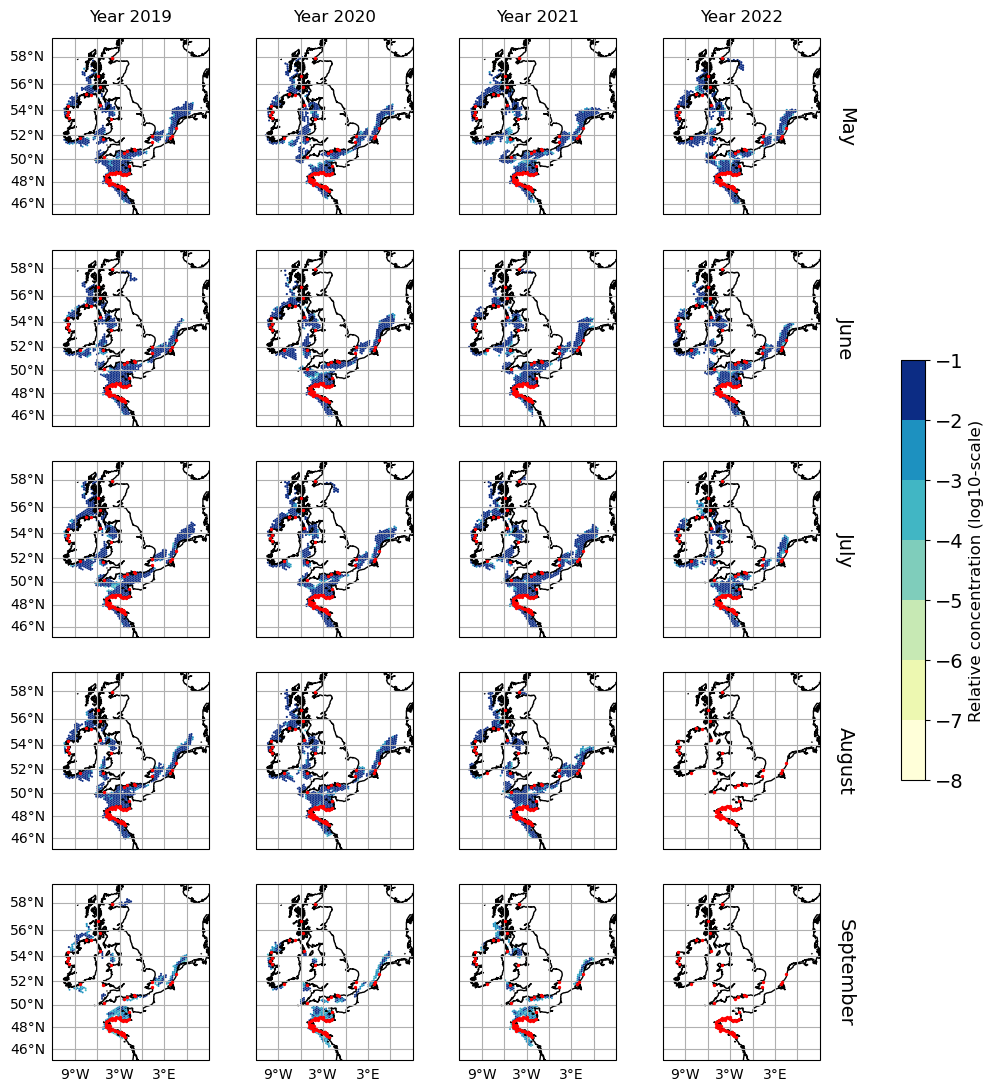

In [59]:
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hex2color

# Get unique years and months because later we want to create subplots for each month in each year
years = ['2019','2020','2021','2022']
months = ['May','June','July','August','September']
levels = [-8, -7, -6, -5, -4, -3, -2, -1]
hex_colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
colors = [hex2color(hex_color) for hex_color in hex_colors]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(levels))
norm = BoundaryNorm(levels, cmap.N)

# Create subplots 
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, 
                         subplot_kw={"projection": cartopy.crs.Mercator()}, 
                         figsize=(12, 14))

#now fill in plots
for i, year in enumerate(years):
    for j, month in enumerate(months):
        ax = axes [j,i]
        p = PatchCollection(
            hex_patches, cmap=cmap,
            norm=norm,
            alpha=1.0,
            linewidth=0.1,
            transform=cartopy.crs.PlateCarree(),
            zorder=0)

        current_relative_concentration = np.log10(
            relative_concentration_monthly.sel(year=year, month=month)
        )

        p.set_array(current_relative_concentration)

        ax.add_collection(p, autolim=True)

        ax.scatter(
            dss_to_habitable_01y.lon_hex0, dss_to_habitable_01y.lat_hex0,
            s=2, 
            c="red",
            transform=cartopy.crs.PlateCarree()
        )
        ax.coastlines(zorder=0);
        
        ax.set_extent([-12, 9, 45, 59])
        gl = ax.gridlines(draw_labels=False, zorder=0)
        
        if j == num_months - 1 and month == 'September':
            gl.bottom_labels=True
            gl.top_labels=False
            gl.right_labels=False
        else:
            gl.bottom_labels=False
            gl.top_labels=False
            gl.right_labels=False
            
        # Add y-axis labels only to the leftmost column for 2019
        if i == 0 and year == '2019':
            gl.top_labels=False
            gl.right_labels=False
            gl.left_labels=True
        else:
            gl.top_labels=False
            gl.right_labels=False
            gl.left_labels=False

plt.subplots_adjust(right=0.8, bottom=0.15, wspace=0.02)  # Adjust the subplot layout

cbar_ax = fig.add_axes([0.85, 0.35, 0.02, 0.3])  # Adjust position and size
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'Relative concentration (log10-scale)', fontsize=12)

for i, year in enumerate(years):
    axes[0, i].set_title(f'Year {int(year)}', pad=12, size = 12)
    
for j, month in enumerate(months):
    axes[j, -1].annotate(f'{month}', xy=(1.1, 0.5), xycoords='axes fraction', rotation=270, fontsize=14, ha='left', va='center')

plt.show()

fig.savefig("plots/040_connectivity_analysis_dis_hab_permonthyear.pdf")

### 2 Years: Disease to habitable

In [24]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()

habitable_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.habitable_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()

dss_to_habitable_02y = (
    xr.zeros_like(habitable_to_habitable_01y)
    + np.matmul(dss_to_habitable_01y.data, habitable_to_habitable_01y.data)
).compute()

dss_to_habitable_02y 

<xarray.DataArray 'obs_per_origin_area' (hex0: 8377, hex1: 8377)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * hex0       (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lon_hex1   (hex1) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    lat_hex1   (hex1) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'

In [25]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.habitable_hex1 > 0)
)

dss_to_habitable_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

### 3 Year: Diseased to habitable

In [35]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()

_habitable_to_habitable_02y = np.matmul(
    habitable_to_habitable_01y.data, habitable_to_habitable_01y.data)

dss_to_habitable_03y = (
    xr.zeros_like(habitable_to_habitable_01y)
    + np.matmul(dss_to_habitable_01y.data, _habitable_to_habitable_02y)
).compute()

dss_to_habitable_03y

<xarray.DataArray 'obs_per_origin_area' (hex0: 8377, hex1: 8377)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * hex0       (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lon_hex1   (hex1) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    lat_hex1   (hex1) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'

In [31]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.habitable_hex1 > 0)
)

dss_to_habitable_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

CPU times: user 1.13 s, sys: 641 ms, total: 1.77 s
Wall time: 1.45 s


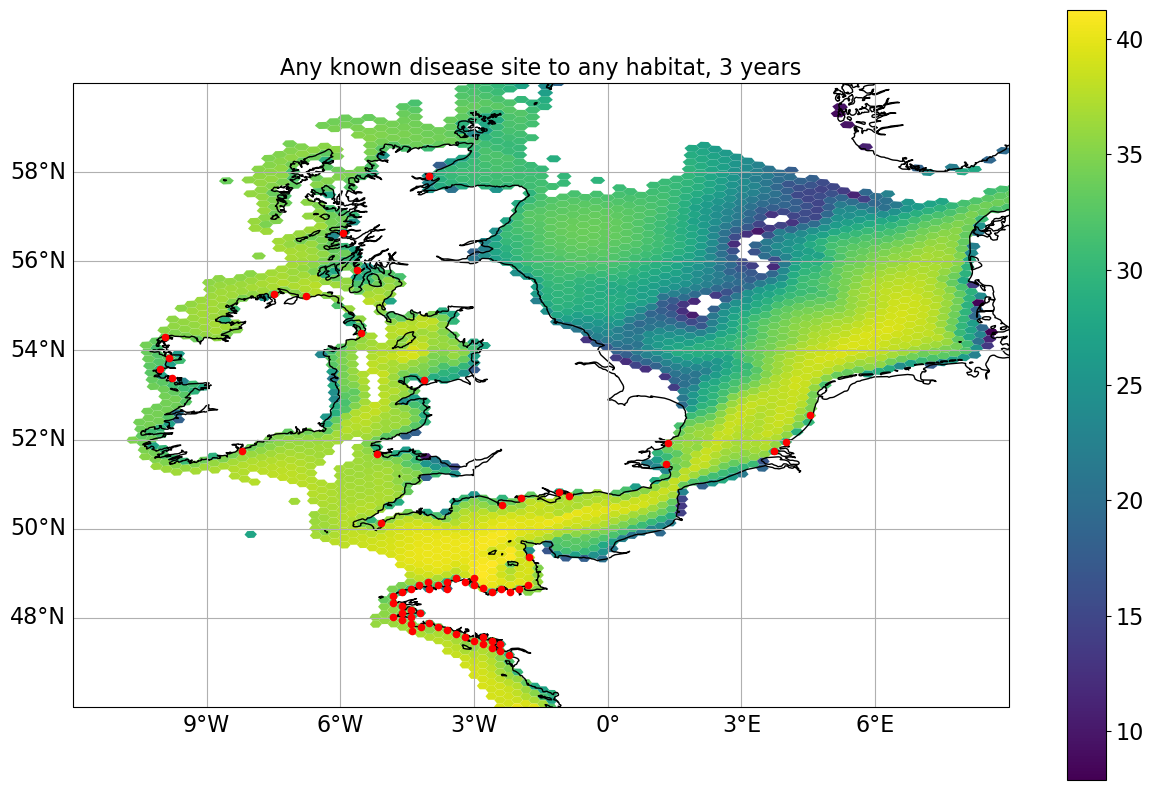

In [32]:
%%time

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();


p = PatchCollection(
    hex_patches,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

#particle number logged
p.set_array(np.log(
    dss_to_habitable_03y.sum(["hex0"]).where(
        dss_to_habitable_03y.sum(["hex0"]) > 0,
    ))
)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=16) 

ax.scatter(
    dss_to_habitable_01y.lon_hex0, dss_to_habitable_01y.lat_hex0,
    s=20, 
    c="red",
    transform=cartopy.crs.PlateCarree()
)

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Any known disease site to any habitat, 3 years", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_dss_habitable_3y.pdf")

### 5 Year: Diseased to habitable

In [26]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()


habitable_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.habitable_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()

_habitable_to_habitable_04y = np.matmul(
    np.matmul(habitable_to_habitable_01y.data, habitable_to_habitable_01y.data),
    np.matmul(habitable_to_habitable_01y.data, habitable_to_habitable_01y.data)
)

dss_to_habitable_05y = (
    xr.zeros_like(habitable_to_habitable_01y)
    + np.matmul(dss_to_habitable_01y.data, _habitable_to_habitable_04y)
).compute()

dss_to_habitable_05y

<xarray.DataArray 'obs_per_origin_area' (hex0: 8377, hex1: 8377)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * hex0       (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lon_hex1   (hex1) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    lat_hex1   (hex1) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'

In [27]:
dss_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.dss_count_hex0 > 0),
    drop=True,
).where(
    (ds_conn.habitable_hex1 > 0)
)

dss_to_habitable_01y

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67, hex1: 8377)>
dask.array<where, shape=(5, 4, 67, 8377), dtype=float64, chunksize=(1, 1, 26, 2100), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lon_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    lat_hex0   (hex0) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    lat_hex1   (hex1) float64 dask.array<chunksize=(2100,), meta=np.ndarray>
    hex_label  (hex0) object dask.array<chunksize=(15,), meta=np.ndarray>

CPU times: user 939 ms, sys: 611 ms, total: 1.55 s
Wall time: 1.24 s


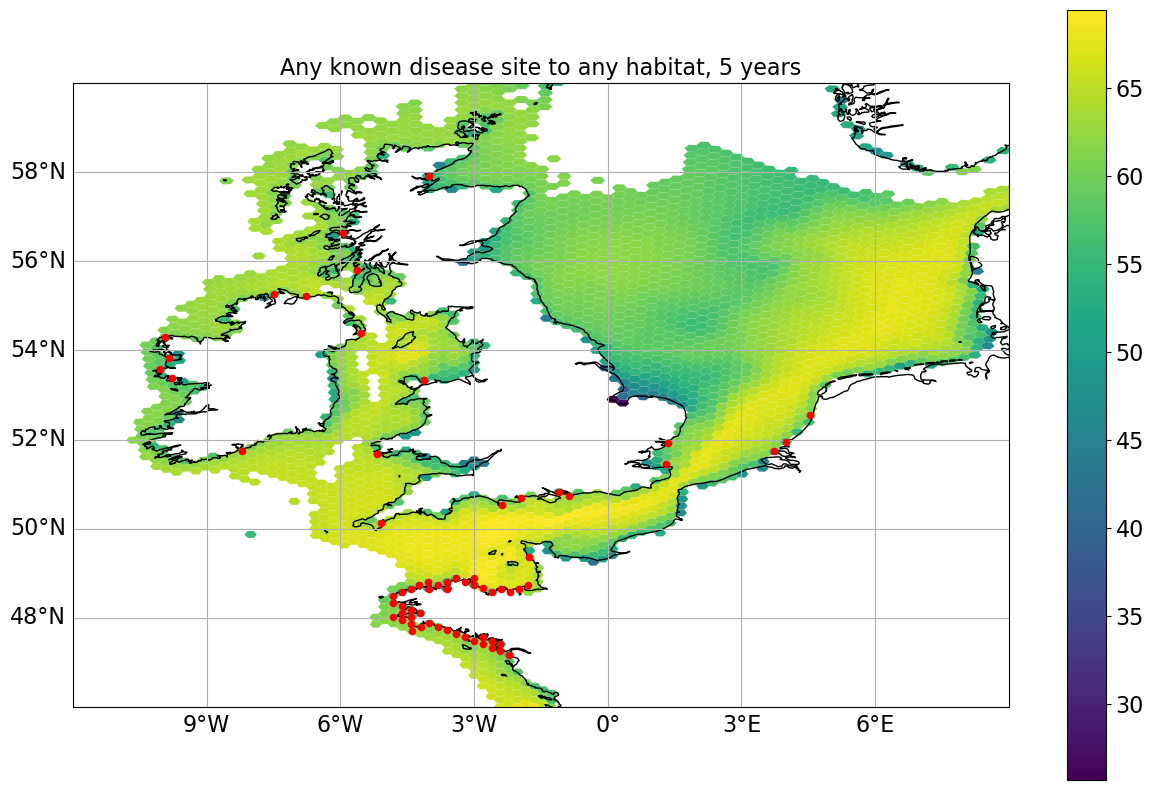

In [29]:
%%time

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();


p = PatchCollection(
    hex_patches,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

#particle number logged
p.set_array(np.log(
    dss_to_habitable_05y.sum(["hex0"]).where(
        dss_to_habitable_05y.sum(["hex0"]) > 0,
    ))
)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=16) 

ax.scatter(
    dss_to_habitable_01y.lon_hex0, dss_to_habitable_01y.lat_hex0,
    s=20, 
    c="red",
    transform=cartopy.crs.PlateCarree()
)

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Any known disease site to any habitat, 5 years", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_dss_habitable_5y.pdf")

### Any habitat to any habitat (= dispersal in the entire North Sea)

In [14]:
hex_patches = []
for _lon, _lat in zip(
    ds_conn.lon_hex1_corners.data.T,
    ds_conn.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 


fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();

cmap = cmocean.cm.dense

p = PatchCollection(
    hex_patches, cmap=cmap,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

#particle number logged
p.set_array(
    habitable_to_habitable_01y.sum(["hex0", "year", "month"]).where(
        habitable_to_habitable_01y.sum(["hex0", "year", "month"]) > 0,
    )
)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Habitable-habitable, dispersal after 1 year", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_habitable-habitable_1y.pdf", dpi=300, bbox_inches='tight')

KeyboardInterrupt: 

In [41]:
#calculate characteristic dist 

delta_dist = dist_thresholds.values[1] - dist_thresholds.values[0]

dist_characteristic = dist_kernels.sum("dist") * delta_dist
dist_characteristic

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 67)>
array([[[ 57.95629429,  57.07385746,  47.69761548, ...,  45.37302296,
          11.33512184,   0.        ],
        [ 50.94169706,  62.58900005,  60.36399502, ...,  55.80599796,
           9.99296526,   0.        ],
        [ 45.95436594,  98.3800417 ,  78.5768426 , ...,  61.11989124,
           9.16817845,  20.6486737 ],
        [ 50.98726123,  56.11132699,  43.34272165, ...,  49.03167061,
          11.20568268,   0.        ]],

       [[ 77.09056161,  71.96009233,  65.34530474, ...,  55.82798994,
          12.95216842,   0.        ],
        [ 52.04180791,  56.40359825,  40.98637514, ...,  44.9356156 ,
          11.33905211,  23.4636121 ],
        [ 54.86497139,  58.58064089,  85.58460946, ...,  45.16607769,
          12.68094824,   0.        ],
        [ 59.80688464,  63.46642125,  46.92172113, ...,  44.64490297,
          11.47475747,   0.        ]],

       [[ 63.36153481,  79.85384124,  56.69856547, ...,  51.43923453,
          21.15527024,   0.        ],
...
        [ 78.87981594,  65.32932793,  44.55745551, ...,  55.48426048,
          13.71218666,   0.        ]],

       [[ 84.84178019,  62.05258296,  32.61695964, ...,  68.36651332,
          20.27185167,   0.        ],
        [ 91.64166089,  55.81773254,  36.99965718, ...,  61.71888982,
          22.61356517,   0.        ],
        [108.73809736,  68.47198051,  53.29761605, ...,  76.65625945,
          22.54263319,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,  22.81490202,   0.        , ...,  68.04795033,
          38.00359916,   0.        ],
        [ 90.09974919,  78.28926773,  38.92928826, ...,  66.35956649,
          11.45378744,   0.        ],
        [ 96.10176549,  62.5497979 ,  30.80155971, ...,  37.35875045,
           5.57388695,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * hex0       (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'
  * month      (month) float64 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 -3.204 -3.199 -5.168 ... -1.762 -1.778 -1.085
    lat_hex0   (hex0) float64 48.82 47.57 51.68 50.12 ... 49.35 48.73 50.83
    hex_label  (hex0) object '(-1, -36, 37)' '(-1, -44, 45)' ... '(9, -28, 19)'

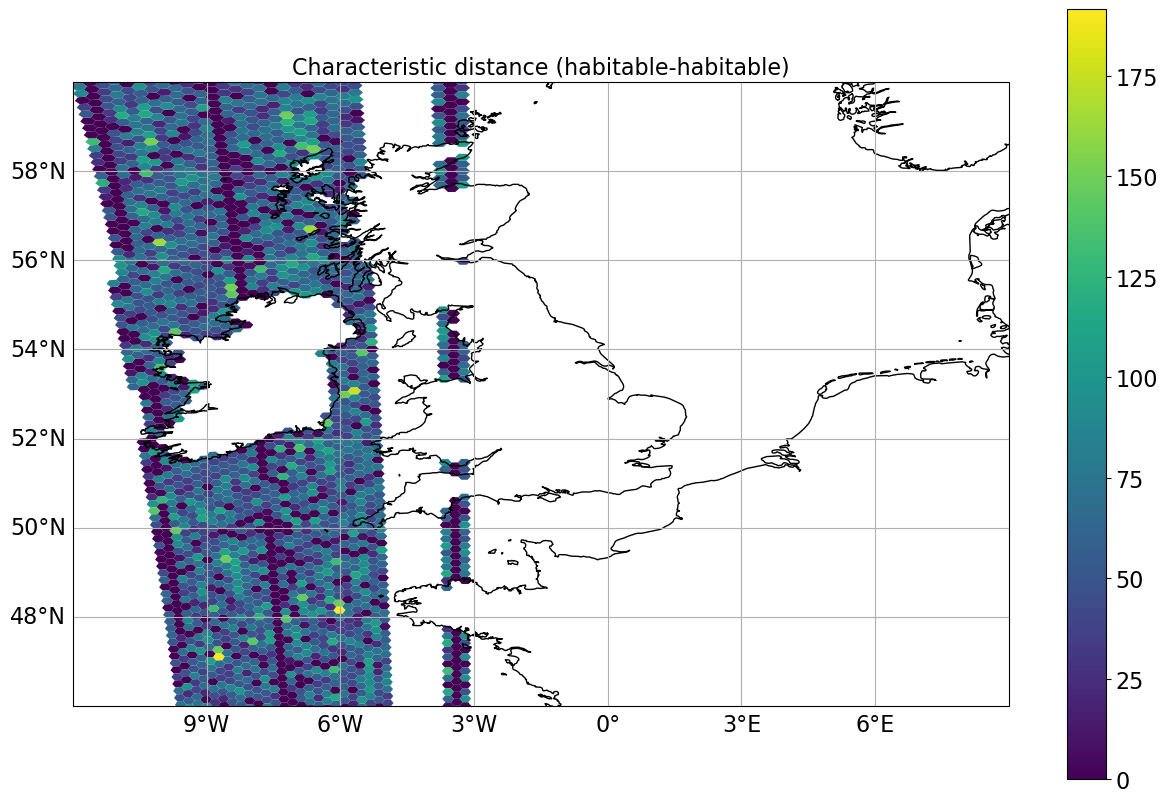

In [42]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();

#cmap = cmocean.cm.dense

p = PatchCollection(
    hex_patches, #cmap=cmap,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

# Flatten the DataArray
flat_data = dist_characteristic.values.ravel()

# Set the 1D array to the PatchCollection
p.set_array(flat_data)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Characteristic distance (habitable-habitable)", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hex0.pdf", dpi=300, bbox_inches='tight')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
import cmocean

# define bin boundaries
bins = [0, 25, 50, 75, 100, 150, 200, 400]

# Create a BoundaryNorm with the defined bins and the colormap
norm = BoundaryNorm(boundaries=bins, ncolors=cmap.N, extend='both')

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(14, 8),
)

fig.tight_layout();

cmap = cmocean.cm.dense

p = PatchCollection(
    hex_patches, cmap=cmap,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

# Flatten the DataArray
flat_data = dist_characteristic.values.ravel()

# Set the 1D array to the PatchCollection
p.set_array(flat_data)

p.set_cmap(cmap)
p.set_norm(norm)

ax.add_collection(p, autolim=True)

#cbar = fig.colorbar(p)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Characteristic distance (habitable-habitable)", fontsize=16);

,
fig.savefig("plots/040_connectivity_analysis_characteristic-distance_categories.pdf", dpi=300, bbox_inches='tight')

ValueError: There are 9 color bins including extensions, but ncolors = 8; ncolors must equal or exceed the number of bins

In [ ]:
hex_patches = []
for _lon, _lat in zip(
    ds_conn.lon_hex1_corners.data.T,
    ds_conn.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

In [25]:
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hex2color

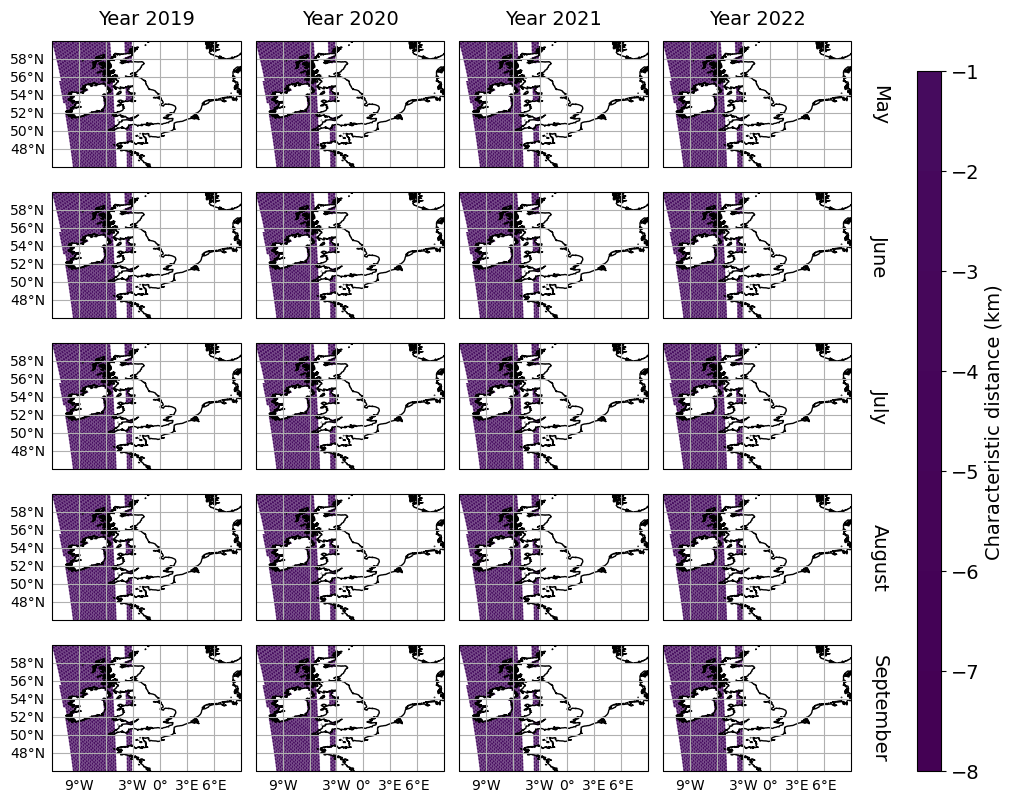

In [33]:
# Map years from string to corresponding numeric values
#year_map = {'2019': 0.0, '2020': 1.0, '2021': 2.0, '2022': 3.0}
#months_map = {'May': 0.0, 'June': 1.0, 'July': 2.0, 'August': 3.0, 'September': 4.0}
year_mapping = {'2019': 0, '2020': 1, '2021': 2, '2022': 3}
month_mapping = {'May': 0, 'June': 1, 'July': 2, 'August': 3, 'September': 4}

# Create subplots
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, 
                         subplot_kw={"projection": cartopy.crs.PlateCarree()}, 
                         figsize=(12, 10))

# Now fill in plots
for i, year_str in enumerate(years):
    for j, month_str in enumerate(months):
        ax = axes[j, i]

        # Convert string labels to numerical indices
        year_idx = year_mapping[year_str]
        month_idx = month_mapping[month_str]

        # Select data for the specific month and year using index-based selection
        data = dist_characteristic.sel(year=year_idx, month=month_idx)

        p = PatchCollection(
            hex_patches,
            norm=norm,
            alpha=1.0,
            linewidth=0.1,
            transform=cartopy.crs.PlateCarree(),
            zorder=0)

        p.set_array(data.values.flatten())  # Use the selected data

        ax.add_collection(p, autolim=True)
        ax.coastlines(zorder=0)
        ax.set_extent([-12, 9, 46, 60])
        gl = ax.gridlines(draw_labels=False, zorder=0)

        # Formatting gridlines and labels
        if j == num_months - 1 and month_str == 'September':
            gl.bottom_labels = True
            gl.top_labels = False
            gl.right_labels = False
        else:
            gl.bottom_labels = False
            gl.top_labels = False
            gl.right_labels = False

        if i == 0 and year_str == '2019':
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = True
        else:
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = False

plt.subplots_adjust(right=0.8, bottom=0.15, wspace=0.02)  # Adjust the subplot layout

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Characteristic distance (km)', fontsize=14)

for i, year_str in enumerate(years):
    axes[0, i].set_title(f'Year {year_str}', pad=12, size=14)

for j, month_str in enumerate(months):
    axes[j, -1].annotate(f'{month_str}', xy=(1.1, 0.5), xycoords='axes fraction', rotation=270, fontsize=14, ha='left', va='center')

plt.show()

fig.savefig("plots/040_connectivity_analysis_characteristic-distance_permonthperyear.pdf")


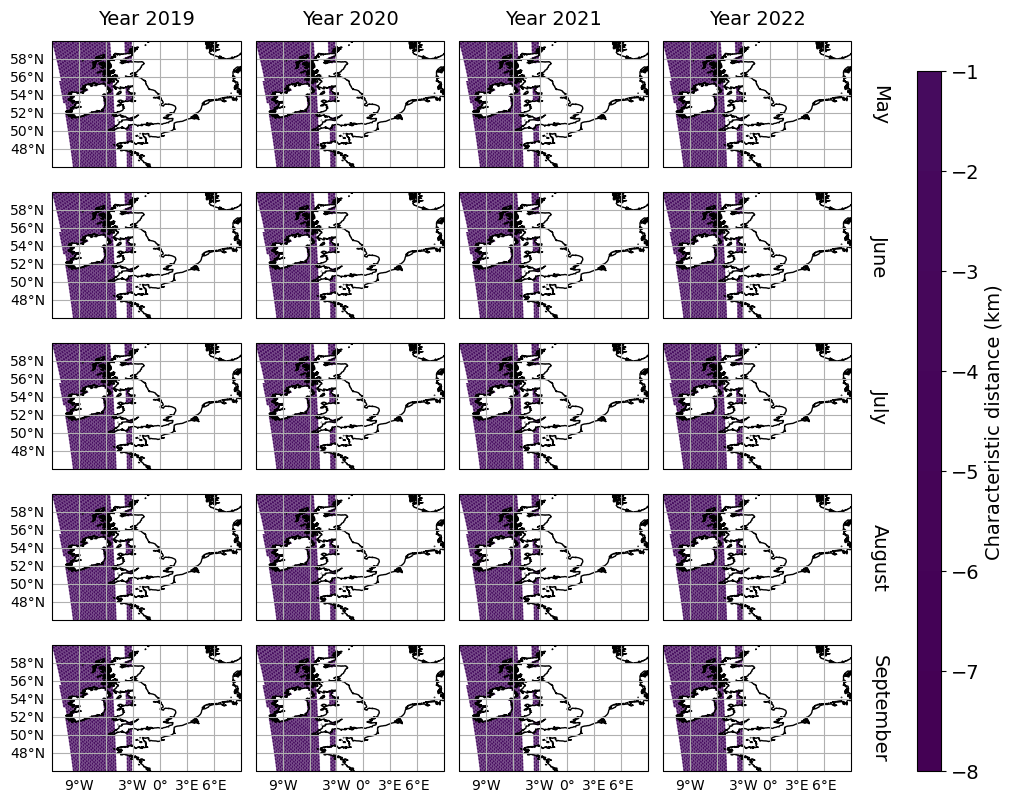

In [35]:
# Map years from string to corresponding numeric values
year_map = {'2019': 0.0, '2020': 1.0, '2021': 2.0, '2022': 3.0}
months_map = {'May': 0.0, 'June': 1.0, 'July': 2.0, 'August': 3.0, 'September': 4.0}
years = ['2019','2020','2021','2022']
months = ['May','June','July','August','September']
levels = [-8, -7, -6, -5, -4, -3, -2, -1]
hex_colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
colors = [hex2color(hex_color) for hex_color in hex_colors]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(levels))
norm = BoundaryNorm(levels, cmap.N)

# Create subplots 
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, 
                         subplot_kw={"projection": cartopy.crs.PlateCarree()}, 
                         figsize=(12, 10))

# Now fill in plots
for i, year_str in enumerate(years):
    #year = year_map[year_str]
    for j, month_str in enumerate(months):
        #month = months_map[month_str]
        ax = axes[j, i]

        # Select data for the specific month and year
        data = dist_characteristic.sel(year=year, month=month)

        p = PatchCollection(
            hex_patches,
            norm=norm,
            alpha=1.0,
            linewidth=0.1,
            transform=cartopy.crs.PlateCarree(),
            zorder=0)

        p.set_array(data.values.flatten())  # Use the selected data

        ax.add_collection(p, autolim=True)
        ax.coastlines(zorder=0)
        ax.set_extent([-12, 9, 46, 60])
        gl = ax.gridlines(draw_labels=False, zorder=0)

        # Formatting gridlines and labels
        if j == num_months - 1 and month_str == 'September':
            gl.bottom_labels = True
            gl.top_labels = False
            gl.right_labels = False
        else:
            gl.bottom_labels = False
            gl.top_labels = False
            gl.right_labels = False

        if i == 0 and year_str == '2019':
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = True
        else:
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = False

plt.subplots_adjust(right=0.8, bottom=0.15, wspace=0.02)  # Adjust the subplot layout

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Characteristic distance (km)', fontsize=14)

for i, year_str in enumerate(years):
    axes[0, i].set_title(f'Year {year_str}', pad=12, size=14)

for j, month_str in enumerate(months):
    axes[j, -1].annotate(f'{month_str}', xy=(1.1, 0.5), xycoords='axes fraction', rotation=270, fontsize=14, ha='left', va='center')

plt.show()

fig.savefig("plots/040_connectivity_analysis_characteristic-distance_permonthperyear.pdf")

### AQC to RST quantification

In [28]:
aqc_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.aqc_count_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()


habitable_to_habitable_01y = ds_conn.obs_per_origin_area.where(
    (ds_conn.habitable_hex0 > 0)
    & (ds_conn.habitable_hex1 > 0)
).sum(["year", "month"]).compute()

_habitable_to_habitable_04y = np.matmul(
    np.matmul(habitable_to_habitable_01y.data, habitable_to_habitable_01y.data),
    np.matmul(habitable_to_habitable_01y.data, habitable_to_habitable_01y.data)
)

aqc_to_rst_05y = (
    xr.zeros_like(habitable_to_habitable_01y)
    + np.matmul(aqc_to_habitable_01y.data, _habitable_to_habitable_04y)
).where(ds_conn.rst_count_hex1 > 0).compute()

aqc_to_rst_05y

<xarray.DataArray 'obs_per_origin_area' (hex0: 8377, hex1: 8377)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * hex0       (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * hex1       (hex1) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lon_hex1   (hex1) float64 -3.216 -3.229 -3.215 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    lat_hex1   (hex1) float64 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) object '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'

In [29]:
aqc_to_rst_05y = aqc_to_rst_05y.where(aqc_to_rst_05y.fillna(0) > 0, drop=True)

CPU times: user 5.95 s, sys: 571 ms, total: 6.52 s
Wall time: 6.55 s


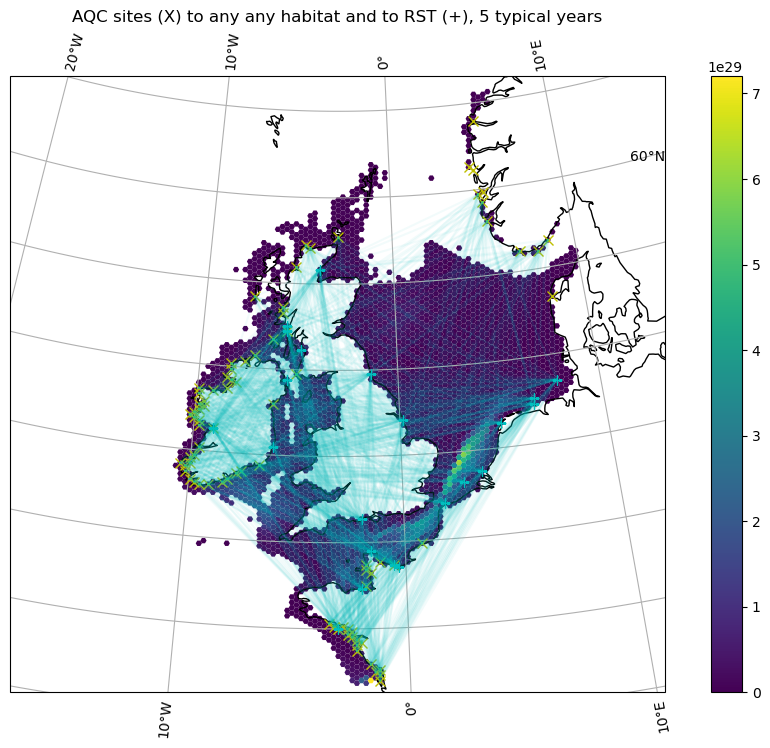

In [30]:
%%time

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_longitude=ds_conn.hex_proj__lon_origin,
        central_latitude=ds_conn.hex_proj__lat_origin,
    )},
    figsize=(12, 8),
)

p = PatchCollection(
    hex_patches, cmap="viridis",
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=-1
)
p.set_array(
    aqc_to_habitable_05y.sum("hex0").where(
        aqc_to_habitable_05y.sum("hex0") > 0
    )
)

ax.plot(
    aqc_to_habitable_05y.lon_hex0.where(ds_conn.aqc_count_hex0 > 0),
    aqc_to_habitable_05y.lat_hex0.where(ds_conn.aqc_count_hex0 > 0),
    'yx',
    markersize=7,
    transform=cartopy.crs.PlateCarree(),
    zorder=10,
)

ax.plot(
    aqc_to_habitable_05y.lon_hex0.where(ds_conn.rst_count_hex0 > 0),
    aqc_to_habitable_05y.lat_hex0.where(ds_conn.rst_count_hex0 > 0),
    'c+',
    markersize=7,
    transform=cartopy.crs.PlateCarree(),
    zorder=10,
)

for h0 in aqc_to_rst_05y.hex0.data:
    for h1 in aqc_to_rst_05y.hex1.data:
        ax.plot(
            [aqc_to_rst_05y.lon_hex0.sel(hex0=h0), aqc_to_rst_05y.lon_hex1.sel(hex1=h1)],
            [aqc_to_rst_05y.lat_hex0.sel(hex0=h0), aqc_to_rst_05y.lat_hex1.sel(hex1=h1)], 
            'c-',
            alpha=0.05,
            transform=cartopy.crs.PlateCarree(),
            zorder=10,
        )

ax.add_collection(p, autolim=True)

fig.colorbar(p)

ax.set_extent([
    ds_conn.lon_hex0_corners.where(ds_conn.lon_hex0 < 10_000).min(),
    ds_conn.lon_hex0_corners.where(ds_conn.lon_hex0 < 10_000).max(), 
    ds_conn.lat_hex0_corners.where(ds_conn.lon_hex0 < 10_000).min() - 1,
    ds_conn.lat_hex0_corners.where(ds_conn.lon_hex0 < 10_000).max(), 
])

ax.coastlines();
ax.gridlines(draw_labels=True);

_ = ax.set_title("AQC sites (X) to any any habitat and to RST (+), 5 typical years");